## URLAnalysis: Detecting Phishing URLs using Machine Learning

**Team:**
* Leonard Ashley
* Amanda Bouton
* Nicholas Haring
* Jeff Oxenberg

**Course:** DAAN 888- Capstone Project

### Problem Statement
The risk of security compromise is ever-increasing.  One prominent vector of compromise is Phishing, in which an adversary masquerades as a benign service with the intention of stealing credentials or other valuable information.  Phishing can take several forms, but in most cases, adversaries rely on directing an unsuspecting user to a malicious URL.  In this project, we explore the detection of malicious Phishing URLs based on parameters and metadata associated with the URL.
We use a dataset available on Kaggle (Kukade, 2022) as the basis to train and compare the performance of several models: Logistic Regression (with and without PCA), XGBoost and Catboost (tree-based models), and multiple Neural Network models.  We find the best performance with XGBoost at ~96% test F1.  We develop a UI system for users to interact with our model via a web-based interface and provide scalability via a model serving API backend.
Phishing is a dynamic problem – techniques to appear benign may change over time.  As such, it is important for our system to continue to evolve to detect these new patterns.  We develop a continual learning system that will ensure our model continues to learn from new data.  We log all model predictions and expect a subject matter expert to perform labeling offline on new data points to provide feedback to the model, with an end-to-end system to retrain and redeploy our model to production.  Finally, we create an end-to-end deployment of our system via Docker Compose to ensure reproducibility.
    
* **Keywords:** Security, Cybersecurity, Phishing, XGBoost, Continual Learning, Explainability

### Data Collection
* Source(url): Kukade, R. (2022). phishing-domain-detection. Retrieved from Kaggle: https://www.kaggle.com/datasets/ravirajkukade/phishingdomaindetection?select=dataset_full.csv 
* Short Description : The dataset consists of both malicious and benign URL properties

* Keywords: Phishing

### Required packages

In [1]:
import os

from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from catboost.utils import get_confusion_matrix
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
import requests
import shap
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn_evaluation import plot
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from scikeras.wrappers import KerasClassifier
import xgboost as xgb

2022-11-05 15:25:32.422546: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
shap.__version__

'0.41.0'

In [ ]:
np.set_printoptions(suppress=True)

In [2]:
with psycopg2.connect(user='daan', password=os.environ['JUPYTER_TOKEN'], host='pg', port=5432, dbname='phishing_data') as cx:
    data = pd.read_sql_query('select * from full_dataset', cx)

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


### Data Preprocessing

In [3]:
constant_features = [data.columns.get_loc(x) for x in data.nunique()[(data.nunique()==1)].index.to_list()]

In [4]:
constant_feature_names = data.columns[constant_features].to_list()

In [5]:
# drop features that are constant
data.drop(constant_feature_names, axis=1, inplace=True)

In [9]:
data.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,2,0,0,...,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,...,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,...,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3597,0,1,0,0,0,0


In [6]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data.phishing, random_state=42)

In [7]:
cat_features = [X_train.columns.get_loc(x) for x in X_train.nunique()[(X_train.nunique()<3)].index.to_list()]

### Methodology

1. Explan your Deep Learning process / methodology

  We approach the problem as binary classification (malicious/benign).  We test mutiple models against a statistical baseline (logistic regression) to assess their performance.  We perform a grid search for optimal hyperparameters and assess the performance delta between an optimized and default model.  For more information please see the full paper.


2. Introduce the Deep Neural Networks you used in your project
 * Model 1
    * Logistic Regression with and without PCA
 
 * Model 2
    * XGBoost
 
 * Model 3
     * CatBoost 
  
 * Model 4
     * Deep Neural Network 
 
3. Add keywords  
**Keywords:** Security, Cybersecurity, Phishing, XGBoost, Continual Learning, Explainability

## Model Fitting and Validation

## Logistic Regression

In [10]:
model_results = []

In [11]:
cat_feature_names = X_train.columns[cat_features]
numeric_feature_names = X_train.columns.difference(cat_feature_names)

In [12]:
numeric_transformer = MinMaxScaler()
cat_transformer = OneHotEncoder(handle_unknown='infrequent_if_exist')

transform = ColumnTransformer(transformers=[
    ('numeric', numeric_transformer, [X_train.columns.get_loc(x) for x in numeric_feature_names]),
    ('categorical', cat_transformer, [X_train.columns.get_loc(x) for x in cat_feature_names])
])

In [13]:
pipe = Pipeline(steps=[
    ('transform', transform),
    ('predict', LogisticRegression(C=10, max_iter=1000, n_jobs=-1, solver='sag')) 
])

In [14]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  [86, 44, 96, 24, 85, 62, 18,
                                                   80, 34, 52, 70, 7, 40, 58,
                                                   76, 13, 33, 51, 69, 6, 38,
                                                   56, 74, 11, 42, 78, 15, 27,
                                                   19, 45, ...]),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  [22, 25, 26, 31, 41, 48, 49,
                                                   59, 60, 77, 83, 93, 97])])),
                ('predict',
                 LogisticRegression(C=10, max_iter=1000, n_jobs=-1,
                                    solver='sag'))])

In [15]:
train_pred = pipe.predict(X_train)

In [16]:
test_pred = pipe.predict(X_test)

In [17]:
print(classification_report(train_pred, y_train))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     42842
           1       0.92      0.89      0.90     23643

    accuracy                           0.93     66485
   macro avg       0.93      0.92      0.93     66485
weighted avg       0.93      0.93      0.93     66485



In [18]:
print(classification_report(test_pred, y_test))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     14270
           1       0.91      0.89      0.90      7892

    accuracy                           0.93     22162
   macro avg       0.93      0.92      0.92     22162
weighted avg       0.93      0.93      0.93     22162



In [19]:
model_results.append({'model': 'LR_baseline', 
                      'accuracy_train': accuracy_score(train_pred, y_train), 
                      'accuracy_test': accuracy_score(test_pred, y_test), 
                      'f1_train': f1_score(train_pred, y_train), 
                      'f1_test': f1_score(test_pred, y_test), 
                      'roc_auc_train': roc_auc_score(train_pred, y_train), 
                      'roc_auc_test': roc_auc_score(test_pred, y_test)})

### Grid Search

In [20]:
# https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py
scoring = ['accuracy', 'f1', 'roc_auc']

param_grid = {'C': np.logspace(-3, 2, 6)}

pipe = Pipeline(steps=[
    ('transform', transform),
    ('predict', GridSearchCV(LogisticRegression(max_iter=1000, n_jobs=-1, solver='sag'), param_grid, return_train_score=True, refit='f1', scoring=scoring, n_jobs=-1))
])

In [21]:
pipe.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
The max_iter was reached which means the coef_ did not converge


Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  [86, 44, 96, 24, 85, 62, 18,
                                                   80, 34, 52, 70, 7, 40, 58,
                                                   76, 13, 33, 51, 69, 6, 38,
                                                   56, 74, 11, 42, 78, 15, 27,
                                                   19, 45, ...]),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  [22, 25, 26, 31, 41, 48, 49,
                                                   59, 60, 77, 83, 93, 97])])),
                ('predict',
                 GridSearchCV(estimator=LogisticRegression(max_iter=1000,
                                                           n_jobs=-1,
                                                           solver='sag'),
                              n_jobs=-1,
                              param_grid={'C': array([  0.001,   0.01 ,   0.1  ,   1.   ,  10.   , 100.   ])},
                              refit='f1', return_train_score=True,
                              scoring=['accuracy', 'f1', 'roc_auc']))])

In [22]:
pipe.named_steps['predict'].best_params_

{'C': 100.0}

In [23]:
pipe.named_steps['predict'].cv_results_

{'mean_fit_time': array([ 1.30119252,  1.24257402,  2.21012087,  7.42762866, 20.19748497,
        92.013133  ]),
 'std_fit_time': array([0.10507578, 0.07896623, 0.07523107, 0.52160178, 0.89393834,
        1.31023867]),
 'mean_score_time': array([0.01550579, 0.01377411, 0.01625929, 0.01227756, 0.0128242 ,
        0.01155539]),
 'std_score_time': array([0.00342049, 0.00162474, 0.00586377, 0.00070214, 0.00118135,
        0.00037398]),
 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1.0},
  {'C': 10.0},
  {'C': 100.0}],
 'split0_test_accuracy': array([0.86026923, 0.89065203, 0.91110777, 0.92276453, 0.9269008 ,
        0.92893134]),
 'split1_test_accuracy': array([0.86184854, 0.89373543, 0.91546965, 0.92675039, 0.93058585,
        0.93111228]),
 'split2_test_accuracy': array([0.86034444, 0.892532

In [24]:
train_pred = pipe.predict(X_train)

In [25]:
test_pred = pipe.predict(X_test)

In [26]:
print(classification_report(train_pred, y_train))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     43041
           1       0.91      0.90      0.91     23444

    accuracy                           0.93     66485
   macro avg       0.93      0.93      0.93     66485
weighted avg       0.93      0.93      0.93     66485



In [27]:
print(classification_report(test_pred, y_test))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     14337
           1       0.91      0.89      0.90      7825

    accuracy                           0.93     22162
   macro avg       0.93      0.92      0.92     22162
weighted avg       0.93      0.93      0.93     22162



In [28]:
model_results.append({'model': 'LR_grid', 
                      'accuracy_train': accuracy_score(train_pred, y_train), 
                      'accuracy_test': accuracy_score(test_pred, y_test), 
                      'f1_train': f1_score(train_pred, y_train), 
                      'f1_test': f1_score(test_pred, y_test), 
                      'roc_auc_train': roc_auc_score(train_pred, y_train), 
                      'roc_auc_test': roc_auc_score(test_pred, y_test)})

### LR with PCA

In [148]:
pca_pipe = Pipeline(steps=[
    ('transform', transform),
    ('pca', PCA()),
    ('predict', LogisticRegression(C=10, max_iter=1000, n_jobs=-1, solver='sag')) 
])

In [149]:
pca_pipe.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  [86, 44, 96, 24, 85, 62, 18,
                                                   80, 34, 52, 70, 7, 40, 58,
                                                   76, 13, 33, 51, 69, 6, 38,
                                                   56, 74, 11, 42, 78, 15, 27,
                                                   19, 45, ...]),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  [22, 25, 26, 31, 41, 48, 49,
                                                   59, 60, 77, 83, 93, 97])])),
                ('pca', PCA()),
                ('predict',
                 LogisticRegression(C=10, max_iter=1000, n_jobs=-1,
                                    solver='sag'))])

Text(0, 0.5, '% explained variance')

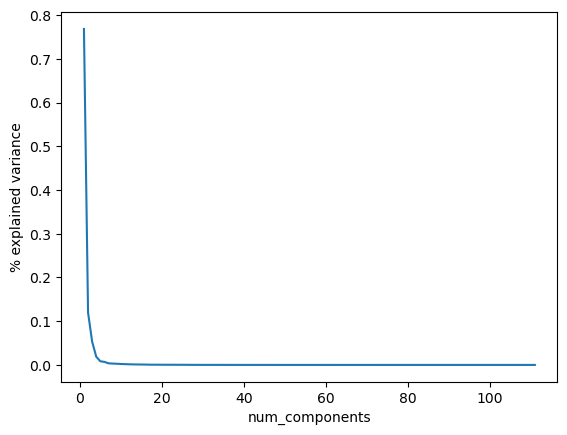

In [150]:
plt.plot((np.arange(pca_pipe.named_steps['pca'].n_components_) + 1), pca_pipe.named_steps['pca'].explained_variance_ratio_)
plt.xlabel('num_components')
plt.ylabel('% explained variance')

In [151]:
pca_pipe.named_steps['pca'].explained_variance_ratio_

array([0.76843227, 0.11987717, 0.05316217, 0.01878635, 0.00832194,
       0.00692803, 0.00365641, 0.00309916, 0.00268204, 0.00213609,
       0.00181465, 0.00144764, 0.00121476, 0.00105146, 0.00097274,
       0.00077251, 0.00060153, 0.00049256, 0.00046566, 0.00043191,
       0.00038564, 0.0003632 , 0.00034675, 0.00032576, 0.00030166,
       0.0002401 , 0.00017585, 0.00013337, 0.00011455, 0.00009964,
       0.00009714, 0.00008212, 0.00008143, 0.00007949, 0.0000763 ,
       0.00006357, 0.0000584 , 0.00004952, 0.00004568, 0.00003814,
       0.00003687, 0.00003517, 0.00003214, 0.00003162, 0.00002948,
       0.00002745, 0.00002658, 0.00002566, 0.00002356, 0.00002129,
       0.00001959, 0.00001788, 0.00001747, 0.00001423, 0.00001372,
       0.00001319, 0.00001252, 0.00001163, 0.00000982, 0.00000946,
       0.00000911, 0.00000723, 0.00000701, 0.00000525, 0.00000481,
       0.00000443, 0.00000407, 0.00000363, 0.00000349, 0.00000325,
       0.00000253, 0.00000229, 0.00000194, 0.00000119, 0.00000

In [152]:
pca_pipe = Pipeline(steps=[
    ('transform', transform),
    ('pca', PCA(n_components=3)),
    ('predict', LogisticRegression(C=10, max_iter=1000, n_jobs=-1, solver='sag')) 
])

In [153]:
pca_pipe.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  [86, 44, 96, 24, 85, 62, 18,
                                                   80, 34, 52, 70, 7, 40, 58,
                                                   76, 13, 33, 51, 69, 6, 38,
                                                   56, 74, 11, 42, 78, 15, 27,
                                                   19, 45, ...]),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  [22, 25, 26, 31, 41, 48, 49,
                                                   59, 60, 77, 83, 93, 97])])),
                ('pca', PCA(n_components=3)),
                ('predict',
                 LogisticRegression(C=10, max_iter=1000, n_jobs=-1,
                                    solver='sag'))])

In [35]:
train_pred_pca = pca_pipe.predict(X_train)

In [36]:
test_pred_pca = pca_pipe.predict(X_test)

In [37]:
print(classification_report(train_pred_pca, y_train))

              precision    recall  f1-score   support

           0       0.80      0.98      0.89     35552
           1       0.98      0.72      0.83     30933

    accuracy                           0.86     66485
   macro avg       0.89      0.85      0.86     66485
weighted avg       0.88      0.86      0.86     66485



In [38]:
print(classification_report(test_pred_pca, y_test))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89     11957
           1       0.98      0.73      0.84     10205

    accuracy                           0.87     22162
   macro avg       0.89      0.86      0.86     22162
weighted avg       0.89      0.87      0.87     22162



In [39]:
model_results.append({'model': 'LR_pca_baseline', 
                      'accuracy_train': accuracy_score(train_pred_pca, y_train), 
                      'accuracy_test': accuracy_score(test_pred_pca, y_test), 
                      'f1_train': f1_score(train_pred_pca, y_train), 
                      'f1_test': f1_score(test_pred_pca, y_test), 
                      'roc_auc_train': roc_auc_score(train_pred_pca, y_train), 
                      'roc_auc_test': roc_auc_score(test_pred_pca, y_test)})

### Grid Search

In [40]:
pca_pipe = Pipeline(steps=[
    ('transform', transform),
    ('pca', PCA(n_components=3)),
    ('predict', GridSearchCV(LogisticRegression(max_iter=1000, n_jobs=-1, solver='sag'), param_grid, return_train_score=True, refit='f1', scoring=scoring, n_jobs=-1)) 
])

In [41]:
pca_pipe.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  [86, 44, 96, 24, 85, 62, 18,
                                                   80, 34, 52, 70, 7, 40, 58,
                                                   76, 13, 33, 51, 69, 6, 38,
                                                   56, 74, 11, 42, 78, 15, 27,
                                                   19, 45, ...]),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  [22, 25, 26, 31, 41, 48, 49,
                                                   59, 60, 77, 83, 93, 97])])),
                ('pca', PCA(n_components=3)),
                ('predict',
                 GridSearchCV(estimator=LogisticRegression(max_iter=1000,
                                                           n_jobs=-1,
                                                           solver='sag'),
                              n_jobs=-1,
                              param_grid={'C': array([  0.001,   0.01 ,   0.1  ,   1.   ,  10.   , 100.   ])},
                              refit='f1', return_train_score=True,
                              scoring=['accuracy', 'f1', 'roc_auc']))])

In [42]:
pca_pipe.named_steps['predict'].best_params_

{'C': 0.001}

In [43]:
pca_pipe.named_steps['predict'].cv_results_

{'mean_fit_time': array([0.16345205, 0.16589074, 0.23693004, 0.34412675, 0.37003999,
        0.34053893]),
 'std_fit_time': array([0.01176893, 0.02540604, 0.0086832 , 0.03664763, 0.03846105,
        0.04605194]),
 'mean_score_time': array([0.0119626 , 0.00883842, 0.01076312, 0.01233683, 0.00957689,
        0.00830822]),
 'std_score_time': array([0.00278491, 0.00038826, 0.00403744, 0.00563439, 0.00069859,
        0.00029392]),
 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1.0},
  {'C': 10.0},
  {'C': 100.0}],
 'split0_test_accuracy': array([0.86026923, 0.86026923, 0.86026923, 0.86026923, 0.86026923,
        0.86026923]),
 'split1_test_accuracy': array([0.86184854, 0.86184854, 0.86184854, 0.86184854, 0.86184854,
        0.86184854]),
 'split2_test_accuracy': array([0.86034444, 0.86034444, 0.

In [44]:
train_pred_pca = pca_pipe.predict(X_train)

In [45]:
test_pred_pca = pca_pipe.predict(X_test)

In [46]:
print(classification_report(train_pred_pca, y_train))

              precision    recall  f1-score   support

           0       0.80      0.98      0.89     35552
           1       0.98      0.72      0.83     30933

    accuracy                           0.86     66485
   macro avg       0.89      0.85      0.86     66485
weighted avg       0.88      0.86      0.86     66485



In [47]:
print(classification_report(test_pred_pca, y_test))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89     11957
           1       0.98      0.73      0.84     10205

    accuracy                           0.87     22162
   macro avg       0.89      0.86      0.86     22162
weighted avg       0.89      0.87      0.87     22162



In [48]:
model_results.append({'model': 'LR_pca_grid', 
                      'accuracy_train': accuracy_score(train_pred_pca, y_train), 
                      'accuracy_test': accuracy_score(test_pred_pca, y_test), 
                      'f1_train': f1_score(train_pred_pca, y_train), 
                      'f1_test': f1_score(test_pred_pca, y_test), 
                      'roc_auc_train': roc_auc_score(train_pred_pca, y_train), 
                      'roc_auc_test': roc_auc_score(test_pred_pca, y_test)})

## XGBoost

In [8]:
# https://xgboost.readthedocs.io/en/stable/python/python_intro.html
clf = xgb.XGBClassifier(tree_method='hist', enable_categorical=True, max_cat_to_onehot=3)

In [9]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=3,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [10]:
train_pred_xgb = clf.predict(X_train)

In [11]:
test_pred_xgb = clf.predict(X_test)

In [12]:
print(classification_report(train_pred_xgb, y_train))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     43597
           1       0.97      0.98      0.97     22888

    accuracy                           0.98     66485
   macro avg       0.98      0.98      0.98     66485
weighted avg       0.98      0.98      0.98     66485



In [13]:
print(classification_report(test_pred_xgb, y_test))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     14467
           1       0.96      0.95      0.95      7695

    accuracy                           0.97     22162
   macro avg       0.97      0.96      0.96     22162
weighted avg       0.97      0.97      0.97     22162



In [18]:
clf.predict_proba(X_test.sample(1))

array([[0.9857191 , 0.01428094]], dtype=float32)

In [19]:
clf.predict_proba(X_test.sample(10))

array([[0.00003743, 0.99996257],
       [0.9947013 , 0.00529866],
       [0.99997425, 0.00002575],
       [0.99879736, 0.00120264],
       [0.9981837 , 0.00181626],
       [0.9976361 , 0.00236389],
       [0.9989115 , 0.00108849],
       [0.99782956, 0.00217043],
       [0.908248  , 0.09175198],
       [0.9999158 , 0.0000842 ]], dtype=float32)

In [57]:
model_results.append({'model': 'xgb_baseline', 
                      'accuracy_train': accuracy_score(train_pred_xgb, y_train), 
                      'accuracy_test': accuracy_score(test_pred_xgb, y_test), 
                      'f1_train': f1_score(train_pred_xgb, y_train), 
                      'f1_test': f1_score(test_pred_xgb, y_test), 
                      'roc_auc_train': roc_auc_score(train_pred_xgb, y_train), 
                      'roc_auc_test': roc_auc_score(test_pred_xgb, y_test)})

### Grid Search

In [58]:
param_grid = {'learning_rate': [1e-2, 5e-2, 1e-1], 'max_depth': [4, 6, 8], 'n_estimators': [100, 500, 1000]}

In [59]:
xgb_grid = GridSearchCV(xgb.XGBClassifier(tree_method='hist', enable_categorical=True, max_cat_to_onehot=3), param_grid, return_train_score=True, refit='f1', scoring=scoring, n_jobs=-1)

In [60]:
xgb_grid.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_o...
                                     min_child_weight=None, missing=nan,
                                     monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [4, 6, 8],
                         'n_estimators': [100, 500, 1000]},
             refit='f1', return_train_score=True,
             scoring=['accuracy', 'f1', 'roc_auc'])

In [61]:
xgb_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 1000}

In [62]:
xgb_grid.cv_results_ 

{'mean_fit_time': array([ 3.84276171, 17.67612329, 30.3749702 ,  4.21984611, 21.68194599,
        36.64383507,  4.95819378, 25.55921206, 45.66813736,  4.05479336,
        13.68781028, 26.1344141 ,  4.86541247, 16.59539404, 30.34026313,
         5.39292598, 18.8840961 , 38.39691696,  3.3986486 , 13.01127582,
        25.42896605,  4.1071022 , 17.95447946, 33.82698736,  5.46252561,
        20.22166739, 39.60179195]),
 'std_fit_time': array([0.10911176, 0.3990064 , 0.35485414, 0.08866175, 0.25234495,
        0.44026649, 0.1449579 , 0.18392199, 1.03310135, 0.19811619,
        0.30213541, 0.51600032, 0.11229617, 0.71579141, 0.63864122,
        0.18847256, 0.42594492, 0.78544162, 0.06411675, 0.20472718,
        0.50540164, 0.10250531, 1.30955606, 1.04867234, 0.65836904,
        0.68709301, 0.73452425]),
 'mean_score_time': array([0.08330107, 0.19887385, 0.35490489, 0.10353875, 0.31420393,
        0.64357872, 0.1257638 , 0.59742641, 1.05414844, 0.08280268,
        0.19412761, 0.36463599, 0.103

In [63]:
train_pred_xgb = xgb_grid.predict(X_train)

In [64]:
test_pred_xgb = xgb_grid.predict(X_test)

In [65]:
print(classification_report(train_pred_xgb, y_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     43514
           1       1.00      1.00      1.00     22971

    accuracy                           1.00     66485
   macro avg       1.00      1.00      1.00     66485
weighted avg       1.00      1.00      1.00     66485



In [66]:
print(classification_report(test_pred_xgb, y_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     14474
           1       0.96      0.96      0.96      7688

    accuracy                           0.97     22162
   macro avg       0.97      0.97      0.97     22162
weighted avg       0.97      0.97      0.97     22162



In [67]:
model_results.append({'model': 'xgb_grid', 
                      'accuracy_train': accuracy_score(train_pred_xgb, y_train), 
                      'accuracy_test': accuracy_score(test_pred_xgb, y_test), 
                      'f1_train': f1_score(train_pred_xgb, y_train), 
                      'f1_test': f1_score(test_pred_xgb, y_test), 
                      'roc_auc_train': roc_auc_score(train_pred_xgb, y_train), 
                      'roc_auc_test': roc_auc_score(test_pred_xgb, y_test)})

## CatBoost

In [68]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [69]:
catboost_model = CatBoostClassifier(iterations=250,
                                    depth=10,
                                    learning_rate=1e-1,
                                    eval_metric='F1'
                                   )

In [70]:
catboost_model.fit(train_pool)

0:	learn: 0.8949237	total: 104ms	remaining: 25.8s
1:	learn: 0.9038120	total: 171ms	remaining: 21.2s
2:	learn: 0.9143085	total: 239ms	remaining: 19.7s
3:	learn: 0.9192387	total: 299ms	remaining: 18.4s
4:	learn: 0.9205643	total: 358ms	remaining: 17.6s
5:	learn: 0.9250478	total: 414ms	remaining: 16.8s
6:	learn: 0.9266708	total: 474ms	remaining: 16.4s
7:	learn: 0.9280310	total: 529ms	remaining: 16s
8:	learn: 0.9288752	total: 596ms	remaining: 15.9s
9:	learn: 0.9309655	total: 656ms	remaining: 15.7s
10:	learn: 0.9324348	total: 711ms	remaining: 15.4s
11:	learn: 0.9328625	total: 766ms	remaining: 15.2s
12:	learn: 0.9332528	total: 838ms	remaining: 15.3s
13:	learn: 0.9344283	total: 891ms	remaining: 15s
14:	learn: 0.9352325	total: 953ms	remaining: 14.9s
15:	learn: 0.9357556	total: 1.01s	remaining: 14.8s
16:	learn: 0.9365847	total: 1.07s	remaining: 14.7s
17:	learn: 0.9372732	total: 1.12s	remaining: 14.5s
18:	learn: 0.9373191	total: 1.18s	remaining: 14.3s
19:	learn: 0.9384183	total: 1.23s	remaining: 

In [71]:
train_pred_cb = catboost_model.predict(train_pool)

In [72]:
test_pred_cb = catboost_model.predict(test_pool)

In [73]:
print(classification_report(train_pred_cb, y_train))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     43633
           1       0.98      0.98      0.98     22852

    accuracy                           0.99     66485
   macro avg       0.98      0.99      0.99     66485
weighted avg       0.99      0.99      0.99     66485



In [74]:
print(classification_report(test_pred_cb, y_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     14478
           1       0.96      0.96      0.96      7684

    accuracy                           0.97     22162
   macro avg       0.97      0.97      0.97     22162
weighted avg       0.97      0.97      0.97     22162



In [75]:
model_results.append({'model': 'cb_baseline', 
                      'accuracy_train': accuracy_score(train_pred_cb, y_train), 
                      'accuracy_test': accuracy_score(test_pred_cb, y_test), 
                      'f1_train': f1_score(train_pred_cb, y_train), 
                      'f1_test': f1_score(test_pred_cb, y_test), 
                      'roc_auc_train': roc_auc_score(train_pred_cb, y_train), 
                      'roc_auc_test': roc_auc_score(test_pred_cb, y_test)})

### Grid Search

In [76]:
param_grid = {'iterations': [200, 250, 300], 'depth': [6, 8, 10], 'learning_rate': [1e-2, 5e-2, 1e-1]}

In [77]:
# https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier_grid_search
cb_grid_model = CatBoostClassifier(eval_metric='F1', logging_level='Silent')
cb_grid_result = cb_grid_model.grid_search(param_grid, train_pool)

0:	loss: 0.9167483	best: 0.9167483 (0)	total: 2.92s	remaining: 1m 16s
1:	loss: 0.9377178	best: 0.9377178 (1)	total: 5.34s	remaining: 1m 6s
2:	loss: 0.9439354	best: 0.9439354 (2)	total: 7.6s	remaining: 1m
3:	loss: 0.9207211	best: 0.9439354 (2)	total: 10.8s	remaining: 1m 2s
4:	loss: 0.9409586	best: 0.9439354 (2)	total: 13.6s	remaining: 60s
5:	loss: 0.9458397	best: 0.9458397 (5)	total: 16.5s	remaining: 57.6s
6:	loss: 0.9237113	best: 0.9458397 (5)	total: 20.2s	remaining: 57.7s
7:	loss: 0.9421253	best: 0.9458397 (5)	total: 23.8s	remaining: 56.5s
8:	loss: 0.9476097	best: 0.9476097 (8)	total: 27s	remaining: 54.1s
9:	loss: 0.9277187	best: 0.9476097 (8)	total: 31s	remaining: 52.7s
10:	loss: 0.9459548	best: 0.9476097 (8)	total: 34.4s	remaining: 50.1s
11:	loss: 0.9510061	best: 0.9510061 (11)	total: 37.9s	remaining: 47.4s
12:	loss: 0.9305556	best: 0.9510061 (11)	total: 42.6s	remaining: 45.8s
13:	loss: 0.9477815	best: 0.9510061 (11)	total: 47.1s	remaining: 43.7s
14:	loss: 0.9526103	best: 0.9526103 

In [78]:
cb_grid_result['params']

{'depth': 10, 'iterations': 300, 'learning_rate': 0.1}

In [79]:
train_pred_cb = cb_grid_model.predict(train_pool)

In [80]:
test_pred_cb = cb_grid_model.predict(test_pool)

In [81]:
print(classification_report(train_pred_cb, y_train))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     43650
           1       0.98      0.99      0.98     22835

    accuracy                           0.99     66485
   macro avg       0.99      0.99      0.99     66485
weighted avg       0.99      0.99      0.99     66485



In [82]:
print(classification_report(test_pred_cb, y_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     14488
           1       0.96      0.96      0.96      7674

    accuracy                           0.97     22162
   macro avg       0.97      0.97      0.97     22162
weighted avg       0.97      0.97      0.97     22162



In [83]:
model_results.append({'model': 'cb_grid', 
                      'accuracy_train': accuracy_score(train_pred_cb, y_train), 
                      'accuracy_test': accuracy_score(test_pred_cb, y_test), 
                      'f1_train': f1_score(train_pred_cb, y_train), 
                      'f1_test': f1_score(test_pred_cb, y_test), 
                      'roc_auc_train': roc_auc_score(train_pred_cb, y_train), 
                      'roc_auc_test': roc_auc_score(test_pred_cb, y_test)})

## Neural Network

In [84]:
# https://gist.github.com/MaxHalford/9bfaa8daf8b4bc17a7fb7ba58c880675
input_dim = len(pipe.named_steps['transform'].get_feature_names_out())
def nn_model():
    model = tf.keras.models.Sequential([
        Dense(128, input_dim=input_dim, activation='relu'),
        # Dropout(0.2),
        Dense(64, activation='relu'),
        # Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=
                  ['accuracy', 'AUC'])
    
    return model

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks
logdir = os.path.join("tensorboard", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cb = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [85]:
nn_pipe = Pipeline(steps=[
    ('transform', transform),
    ('predict', KerasClassifier(model=nn_model, batch_size=32, epochs=100,
                               validation_split=0.2, callbacks=[early_stopping, tensorboard_cb])) 
])

In [86]:
nn_pipe

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  [86, 44, 96, 24, 85, 62, 18,
                                                   80, 34, 52, 70, 7, 40, 58,
                                                   76, 13, 33, 51, 69, 6, 38,
                                                   56, 74, 11, 42, 78, 15, 27,
                                                   19, 45, ...]),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  [22, 25, 26, 31, 41, 48, 49,
                                                   59, 60, 77, 83, 93, 97])])),
                ('predict',
                 KerasClassifier(batch_size=32, callbacks=[<keras.callbacks.EarlyStopping object at 0x7fbc0d991ff0>, <keras.callbacks.TensorBoard object at 0x7fbc0d993a30>], epochs=100, model=<function nn_model at 0x7fbc0dadd2d0>, validation_split=0.2))])

In [87]:
# https://www.adriangb.com/scikeras/stable/migration.html#migration
history = nn_pipe.fit(X_train, y_train)

Epoch 1/100


2022-10-24 15:40:44.788362: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1663/1663 [==============================] - 4s 2ms/step - loss: 0.2102 - accuracy: 0.9140 - auc: 0.9693 - val_loss: 0.1700 - val_accuracy: 0.9311 - val_auc: 0.9805
Epoch 2/100
1663/1663 [==============================] - 3s 2ms/step - loss: 0.1818 - accuracy: 0.9248 - auc: 0.9775 - val_loss: 0.1612 - val_accuracy: 0.9369 - val_auc: 0.9819
Epoch 3/100
1663/1663 [==============================] - 3s 2ms/step - loss: 0.1733 - accuracy: 0.9278 - auc: 0.9795 - val_loss: 0.1623 - val_accuracy: 0.9330 - val_auc: 0.9836
Epoch 4/100
1663/1663 [==============================] - 3s 2ms/step - loss: 0.1657 - accuracy: 0.9312 - auc: 0.9812 - val_loss: 0.1639 - val_accuracy: 0.9265 - val_auc: 0.9835
Epoch 5/100
1663/1663 [==============================] - 3s 2ms/step - loss: 0.1576 - accuracy: 0.9346 - auc: 0.9830 - val_loss: 0.1428 - val_accuracy: 0.9437 - val_auc: 0.9865
Epoch 6/100
1663/1663 [==============================] - 3s 2ms/step - loss: 0.1504 - accuracy: 0.9383 - auc: 0.9845 - val_loss

In [88]:
train_pred_nn = nn_pipe.predict(X_train)

2078/2078 [==============================] - 2s 893us/step


In [89]:
test_pred_nn = nn_pipe.predict(X_test)

693/693 [==============================] - 1s 892us/step


In [90]:
print(classification_report(train_pred_nn, y_train))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     42658
           1       0.95      0.91      0.93     23827

    accuracy                           0.95     66485
   macro avg       0.95      0.94      0.95     66485
weighted avg       0.95      0.95      0.95     66485



In [91]:
print(classification_report(test_pred_nn, y_test))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     14206
           1       0.94      0.91      0.93      7956

    accuracy                           0.95     22162
   macro avg       0.95      0.94      0.94     22162
weighted avg       0.95      0.95      0.95     22162



In [92]:
model_results.append({'model': 'nn_baseline', 
                      'accuracy_train': accuracy_score(train_pred_nn, y_train), 
                      'accuracy_test': accuracy_score(test_pred_nn, y_test), 
                      'f1_train': f1_score(train_pred_nn, y_train), 
                      'f1_test': f1_score(test_pred_nn, y_test), 
                      'roc_auc_train': roc_auc_score(train_pred_nn, y_train), 
                      'roc_auc_test': roc_auc_score(test_pred_nn, y_test)})

In [93]:
history = nn_pipe.named_steps['predict'].history_

In [94]:
%load_ext tensorboard

In [95]:
%tensorboard --logdir=tensorboard/ --port 6006 --bind_all

In [137]:
from tensorflow.keras.utils import plot_model

In [145]:
nn_pipe.named_steps['predict'].best_estimator_.model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               14336     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 24,705
Trainable params: 24,705
Non-trainable params: 0
_________________________________________________________________


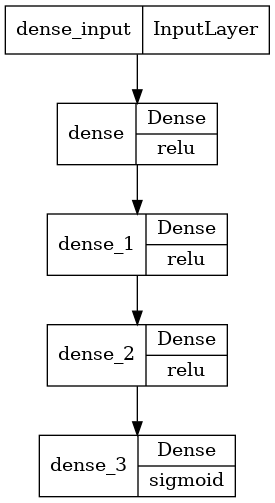

In [140]:
plot_model(nn_pipe.named_steps['predict'].best_estimator_.model_, 
           show_layer_activations=True)

### Grid Search

In [96]:
# clear session/graph
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()

In [97]:
# https://www.adriangb.com/scikeras/stable/quickstart.html#in-an-sklearn-pipeline
# tensorboard callback doesn't work, maybe due to similar issue: https://github.com/keras-team/keras-tuner/issues/574
param_grid = {'optimizer__learning_rate': [1e-3, 1e-2, 1e-1], 'batch_size': [16, 32, 64]}
nn_pipe = Pipeline(steps=[
    ('transform', transform),
    ('predict', GridSearchCV(KerasClassifier(model=nn_model, epochs=100, validation_split=0.2, callbacks=[early_stopping], verbose=0), param_grid, return_train_score=True, refit='f1', scoring=scoring, n_jobs=-1))
     ])

In [98]:
nn_pipe.fit(X_train, y_train)

INFO:tensorflow:Assets written to: ram:///tmp/tmp20i7l60l/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpxgom1ghk/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpg_0__1h_/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp0dkdyssw/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpy5hzhtag/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpe2242qi6/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpjb38_zyw/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmppxuyu3ws/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpjr1ki0dr/assets


2022-10-24 15:41:46.619384: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: ram:///tmp/tmp39xj4wdq/assets


2022-10-24 15:41:47.697711: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: ram:///tmp/tmp4ptxnxri/assets


2022-10-24 15:41:48.176094: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: ram:///tmp/tmpodlf16wz/assets


2022-10-24 15:41:49.118646: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-24 15:41:49.437791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: ram:///tmp/tmp6s18gfb3/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpljglt5oj/assets


2022-10-24 15:41:50.525864: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-24 15:41:51.144840: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: ram:///tmp/tmpu5kqghom/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp5ol4t1k4/assets


2022-10-24 15:41:51.986715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: ram:///tmp/tmp1dk45rmc/assets


2022-10-24 15:41:53.006106: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-24 15:41:53.555527: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: ram:///tmp/tmpx0x0747j/assets


2022-10-24 15:41:54.787738: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: ram:///tmp/tmpbtz29lz5/assets


2022-10-24 15:41:56.666324: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: ram:///tmp/tmp31p6eewv/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpqz33pfkc/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpm9ca1l4x/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpqhwvi_ov/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpv3iyx784/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp7vyhhfo6/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp3vzrwoyz/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp45v2lm6w/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp6ce06uqg/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp3pef3dbg/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp8f091oae/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpuusswtzy/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpovfdufgu/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpp5d0uk1s/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpwafcnv0c/assets
INFO:tensorflow:Assets wr

2022-10-24 15:51:19.382273: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: ram:///tmp/tmp64i9kxfm/assets


2022-10-24 15:51:21.638134: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: ram:///tmp/tmpiz1s_fpd/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmppe0vdzfo/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmppvy8ewe8/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp2ak6jlbf/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpzxbeldox/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpb2lb4niz/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmplqj4fsg_/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpjzs5ml9_/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpwc907pf_/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpcn0c_hr3/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpx3bk34ed/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp4_allx9o/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp7e9uhgsq/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpfe66rbeb/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpy_my57ui/assets
INFO:tensorflow:Assets wr

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  [86, 44, 96, 24, 85, 62, 18,
                                                   80, 34, 52, 70, 7, 40, 58,
                                                   76, 13, 33, 51, 69, 6, 38,
                                                   56, 74, 11, 42, 78, 15, 27,
                                                   19, 45, ...]),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  [22, 25, 26, 31, 41, 48, 49,
                                                   59, 60, 77, 83, 93, 97])])),
                ('predict',
                 GridSearchCV(estimator=KerasClassifier(callbacks=[<keras.callbacks.EarlyStopping object at 0x7fbc0d991ff0>], epochs=100, model=<function nn_model at 0x7fbc0dadd2d0>, validation_split=0.2, verbose=0),
                              n_jobs=-1,
                              param_grid={'batch_size': [16, 32, 64],
                                          'optimizer__learning_rate': [0.001,
                                                                       0.01,
                                                                       0.1]},
                              refit='f1', return_train_score=True,
                              scoring=['accuracy', 'f1', 'roc_auc']))])

In [99]:
nn_pipe.named_steps['predict'].best_params_

{'batch_size': 32, 'optimizer__learning_rate': 0.1}

In [100]:
train_pred_nn = nn_pipe.predict(X_train)

In [101]:
test_pred_nn = nn_pipe.predict(X_test)

In [102]:
print(classification_report(train_pred_nn, y_train))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     43300
           1       0.94      0.93      0.93     23185

    accuracy                           0.95     66485
   macro avg       0.95      0.95      0.95     66485
weighted avg       0.95      0.95      0.95     66485



In [103]:
print(classification_report(test_pred_nn, y_test))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     14401
           1       0.93      0.92      0.93      7761

    accuracy                           0.95     22162
   macro avg       0.95      0.94      0.94     22162
weighted avg       0.95      0.95      0.95     22162



In [104]:
model_results.append({'model': 'nn_grid', 
                      'accuracy_train': accuracy_score(train_pred_nn, y_train), 
                      'accuracy_test': accuracy_score(test_pred_nn, y_test), 
                      'f1_train': f1_score(train_pred_nn, y_train), 
                      'f1_test': f1_score(test_pred_nn, y_test), 
                      'roc_auc_train': roc_auc_score(train_pred_nn, y_train), 
                      'roc_auc_test': roc_auc_score(test_pred_nn, y_test)})

### Model Evaluation 

In [105]:
results_df = pd.DataFrame(model_results)

In [106]:
results_df

,model,accuracy_train,accuracy_test,f1_train,f1_test,roc_auc_train,roc_auc_test
0,LR_baseline,0.932707,0.930512,0.904041,0.901016,0.923448,0.921037
1,LR_grid,0.933805,0.931459,0.905202,0.901943,0.925258,0.922675
2,LR_pca_baseline,0.863488,0.868739,0.831658,0.837222,0.854476,0.858800
3,LR_pca_grid,0.863488,0.868739,0.831658,0.837222,0.854476,0.858800
4,xgb_baseline,0.982688,0.968189,0.974907,0.954105,0.981310,0.964472
5,xgb_grid,0.999789,0.972836,0.999695,0.960792,0.999819,0.969691
6,cb_baseline,0.986719,0.970129,0.980734,0.956873,0.985953,0.966756
7,cb_grid,0.988810,0.970490,0.983761,0.957366,0.988356,0.967287
8,nn_baseline,0.951388,0.948561,0.930952,0.927026,0.943229,0.940107
9,nn_grid,0.953553,0.949237,0.933111,0.927076,0.947852,0.942820


In [107]:
results_df.to_csv()

',model,accuracy_train,accuracy_test,f1_train,f1_test,roc_auc_train,roc_auc_test\n0,LR_baseline,0.9327066255546363,0.930511686670878,0.9040408373369938,0.9010155546985473,0.9234476446449559,0.9210369508334485\n1,LR_grid,0.9338046175829134,0.9314592545799115,0.9052019386106622,0.9019430637144149,0.9252581789532675,0.9226749127182934\n2,LR_pca_baseline,0.8634880048131157,0.8687392834581716,0.8316578254256779,0.837222315483185,0.854476067151376,0.8587999575647458\n3,LR_pca_grid,0.8634880048131157,0.8687392834581716,0.8316578254256779,0.837222315483185,0.854476067151376,0.8587999575647458\n4,xgb_baseline,0.9826878243212754,0.9681887916253046,0.9749067997994288,0.9541045504849945,0.9813102076085854,0.9644715878439574\n5,xgb_grid,0.9997894261863578,0.9728363866077069,0.9996953342618383,0.9607919760323043,0.9998185801923382,0.9696906735921902\n6,cb_baseline,0.9867188087538542,0.9701290497247541,0.9807344053411298,0.9568729641693811,0.9859529054116704,0.9667557857084353\n7,cb_grid,0.9888095059

In [108]:
results_df.model.loc[results_df.accuracy_test.idxmax()]

'xgb_grid'

In [109]:
results_df.model.loc[results_df.f1_test.idxmax()]

'xgb_grid'

In [110]:
results_df.model.loc[results_df.roc_auc_test.idxmax()]

'xgb_grid'

#### Logistic Regression

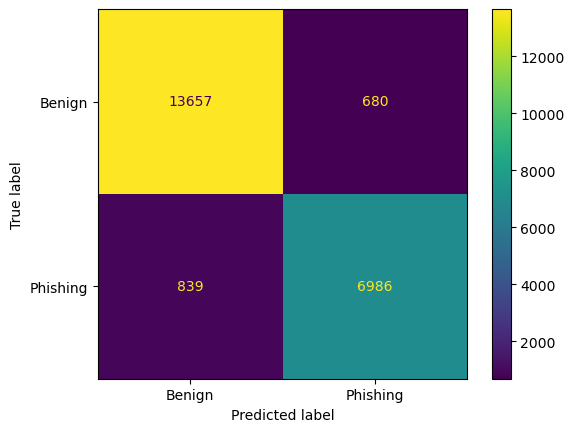

In [111]:
cm = ConfusionMatrixDisplay(confusion_matrix(test_pred, y_test), display_labels=['Benign', 'Phishing'])
cm.plot()

<AxesSubplot:title={'center':'ROC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

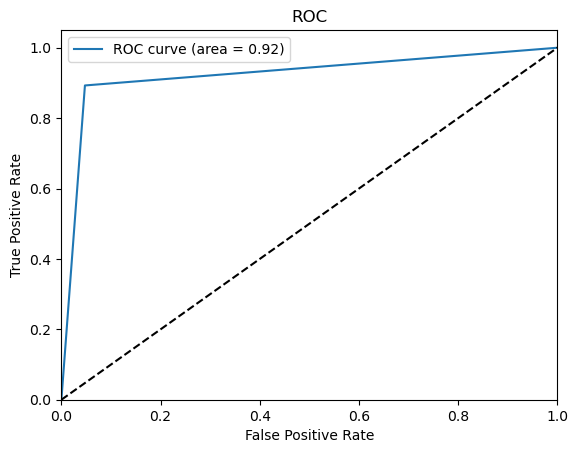

In [112]:
# https://sklearn-evaluation.readthedocs.io/en/latest/user_guide/classifier.html
plot.roc(test_pred, y_test)

#### LR with PCA

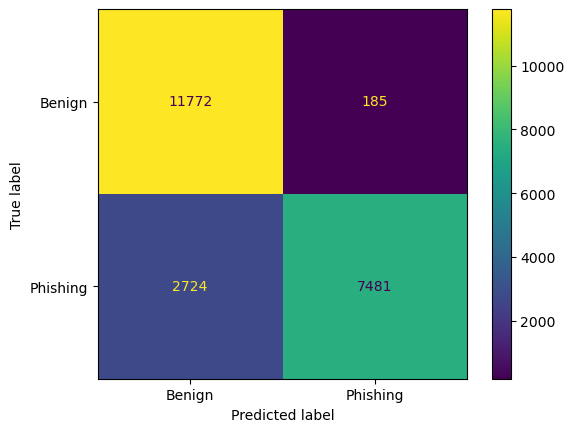

In [113]:
cm = ConfusionMatrixDisplay(confusion_matrix(test_pred_pca, y_test), display_labels=['Benign', 'Phishing'])
cm.plot()

<AxesSubplot:title={'center':'ROC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

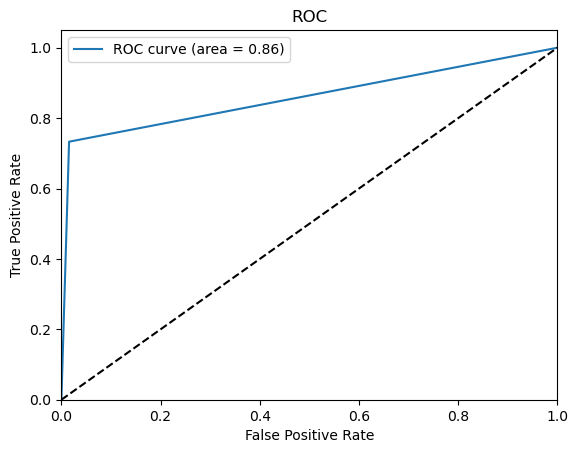

In [114]:
plot.roc(test_pred_pca, y_test)

#### XGBoost

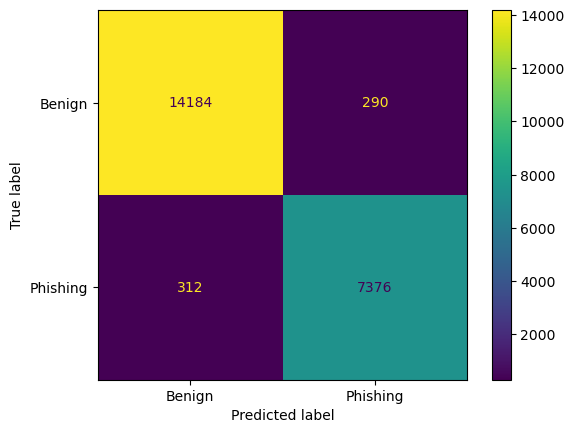

In [115]:
cm = ConfusionMatrixDisplay(confusion_matrix(test_pred_xgb, y_test), display_labels=['Benign', 'Phishing'])
cm.plot()

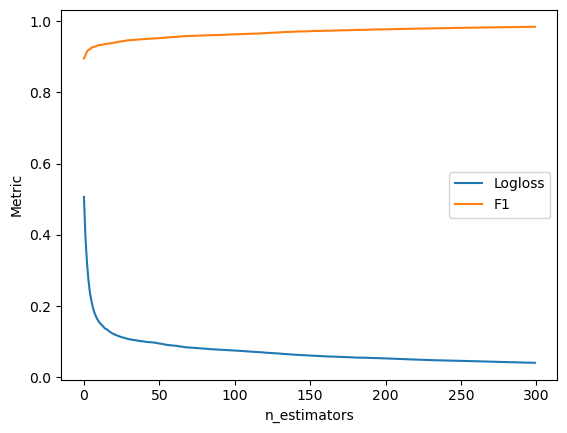

In [146]:
plt.plot(cb_grid_model.get_evals_result()['learn']['Logloss'], label='Logloss')
plt.plot(cb_grid_model.get_evals_result()['learn']['F1'], label='F1')
plt.xlabel("n_estimators")
plt.ylabel("Metric")
plt.legend()

<AxesSubplot:title={'center':'ROC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

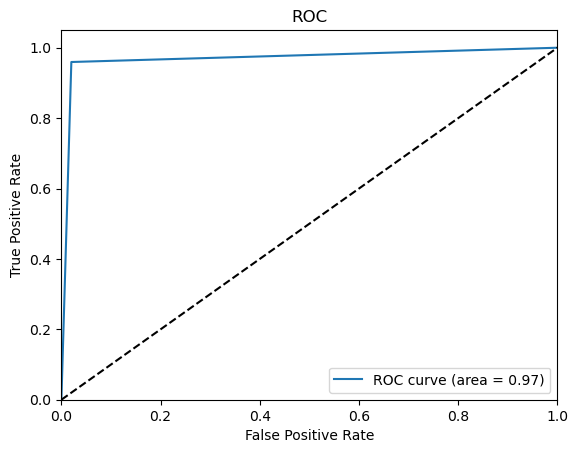

In [117]:
plot.roc(test_pred_xgb, y_test)

#### CatBoost

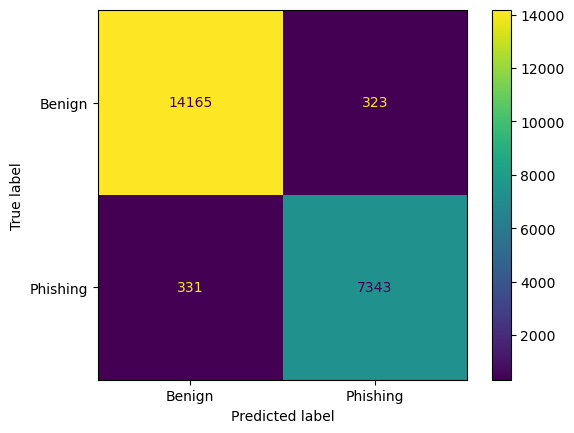

In [118]:
cm = ConfusionMatrixDisplay(confusion_matrix(test_pred_cb, y_test), display_labels=['Benign', 'Phishing'])
cm.plot()

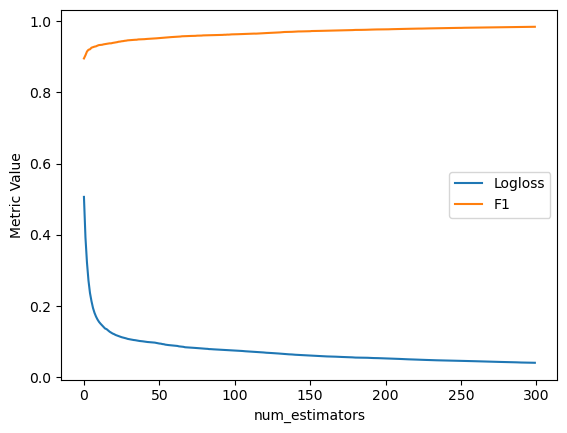

In [119]:
plt.plot(cb_grid_model.get_evals_result()['learn']['Logloss'], label='Logloss')
plt.plot(cb_grid_model.get_evals_result()['learn']['F1'], label='F1')
plt.xlabel("num_estimators")
plt.ylabel("Metric Value")
plt.legend()

<AxesSubplot:title={'center':'ROC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

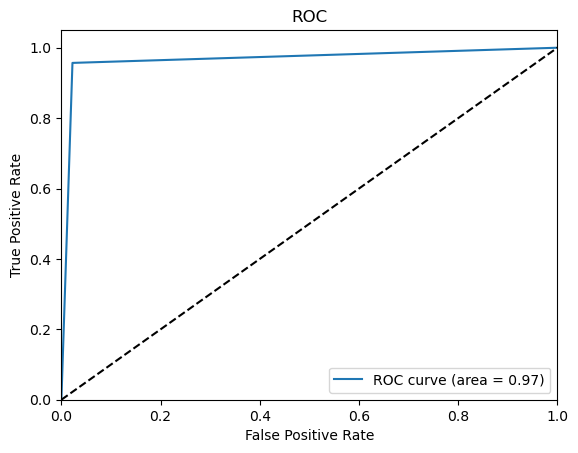

In [120]:
plot.roc(test_pred_cb, y_test)

#### Neural Network

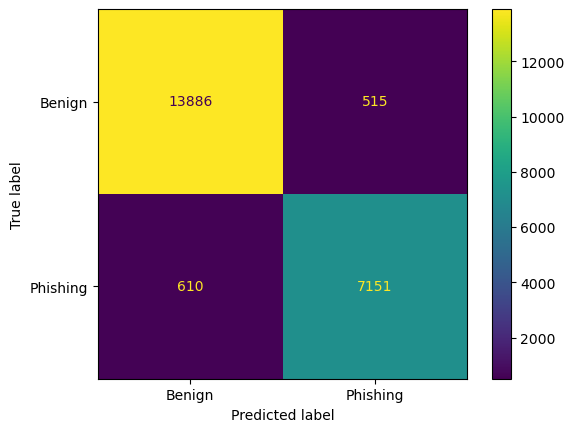

In [121]:
cm = ConfusionMatrixDisplay(confusion_matrix(test_pred_nn, y_test), display_labels=['Benign', 'Phishing'])
cm.plot()

<AxesSubplot:title={'center':'ROC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

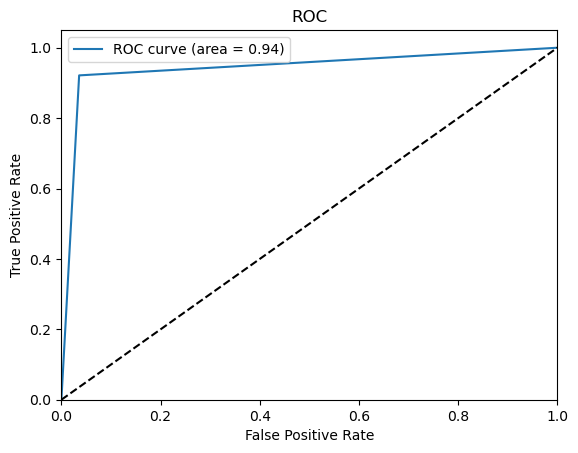

In [122]:
plot.roc(test_pred_nn, y_test)

## SHAP Explainability

In [14]:
# https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Basic%20SHAP%20Interaction%20Value%20Example%20in%20XGBoost.html
preds = clf.predict(X_test)
exp = shap.TreeExplainer(clf)
shap_values = exp.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


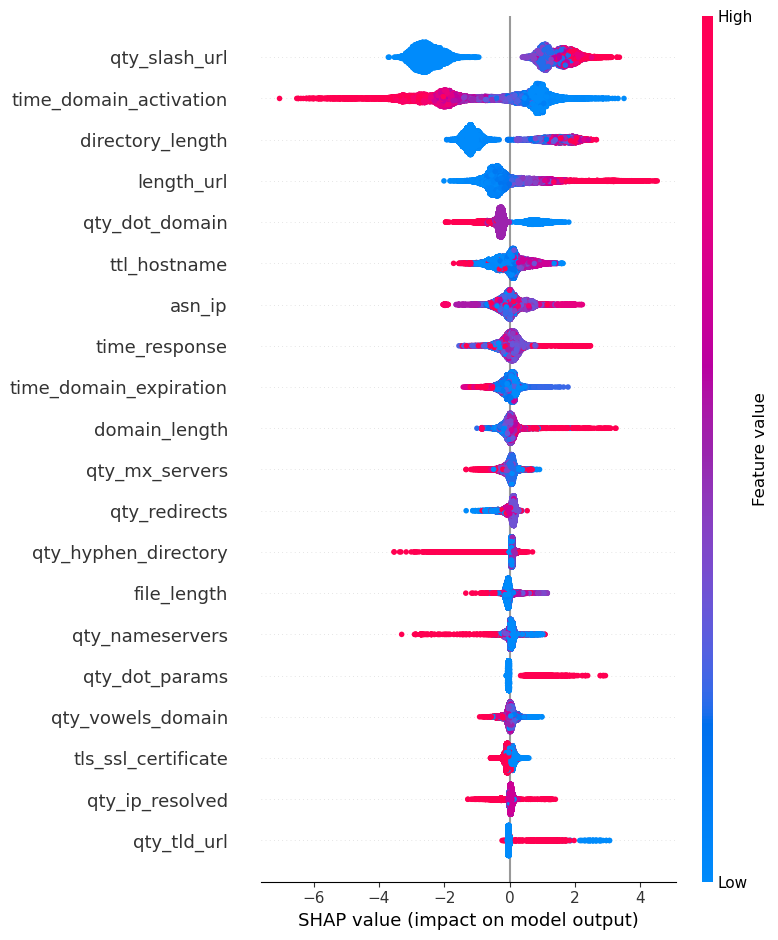

In [124]:
shap.summary_plot(shap_values, X_test)

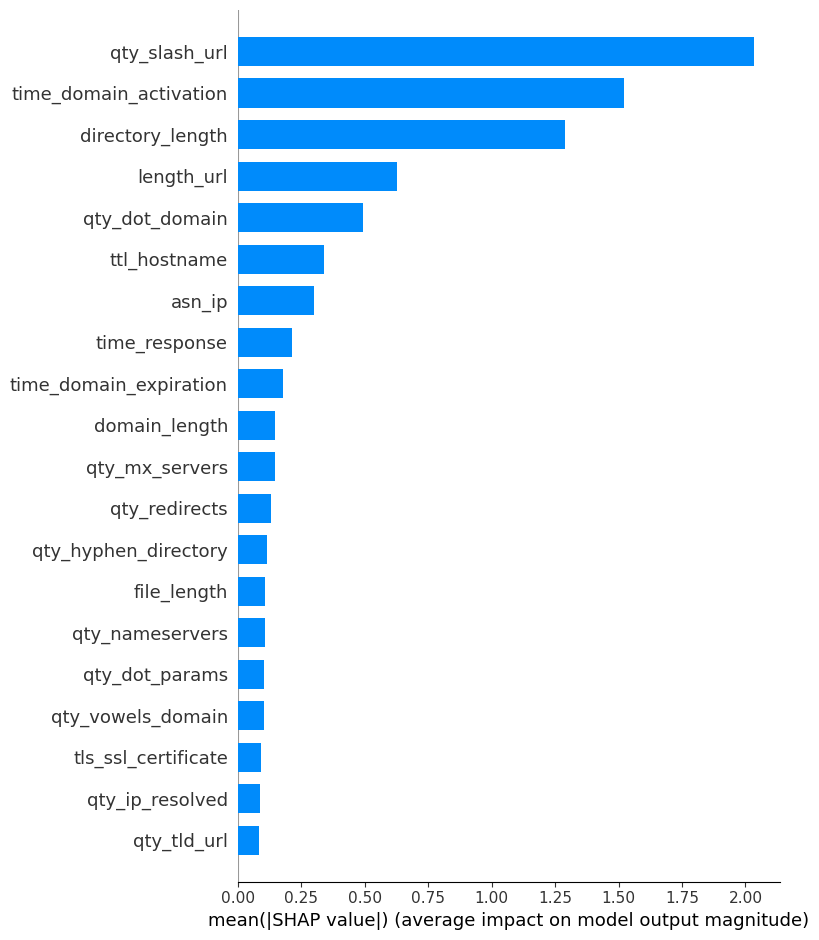

In [125]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [15]:
shap.initjs()

### Deployment

In [18]:
clf.save_model('../models/xgb.json')

In [1]:
!cd ../prefect && python deployment.py

In [142]:
resp = requests.post('http://prefect:4200/api/deployments/filter', json={"name": {"like_": "XGB"}})

In [143]:
dep = resp.json()[0]['id']

In [144]:
dep

'bebb3129-8cbc-4c2c-99f6-34e9da62a135'

### Issues 
* The model was trained and tested on a specific set of data, and we may see a different distribution of data in production
* There is no authentication/authorization for the UI of the system.  
* We did not undertake a rigorous security audit 
* We should additionally undertake a user privacy analysis 
* Streamlit UI is great for prototyping but will suffer scalability issues

Improvements
* Improving Model Interpretability
* Implement Drift Detection
* Implement Model Optionality

For more information please see the full report

### References

(andfanilo), F. A. (2020, September). Display SHAP diagrams with Streamlit. Retrieved from Using Streamlit - Streamlit: https://discuss.streamlit.io/t/display-shap-diagrams-with-streamlit/1029/9

(andfanilo), F. A. (2020, December). Issue with asyncio run in streamlit. Retrieved from Streamlit: https://discuss.streamlit.io/t/issue-with-asyncio-run-in-streamlit/7745/7

Adler, D. (2018, October 2). python - Extract email sub-strings from large document. Retrieved from Stack Overflow: https://stackoverflow.com/questions/17681670/extract-email-sub-strings-from-large-document

Arora, N. (2021, September 9). SSL Certificate Verification - Python requests. Retrieved from GeeksForGeeks: https://www.geeksforgeeks.org/ssl-certificate-verification-python-requests/

Azoff, J., & Castell, V. H. (2016, November 7). JustinAzoff/python-cymruwhois: Python client for the whois.cymru.com service. Retrieved from github.com: https://github.com/JustinAzoff/python-cymruwhois

Badaracco, A. G., & scikeras developers. (2020). Migrating from tf.keras.wrappers.scikit_learn. Retrieved from SciKeras 0.9.0 documentation: https://www.adriangb.com/scikeras/stable/migration.html#migration

Badaracco, A. G., & SciKeras developers. (2020). Quickstart. Retrieved from SciKeras 0.9.0 documentation: https://www.adriangb.com/scikeras/stable/quickstart.html#in-an-sklearn-pipeline

Brinkmann, J. (2018). Read SQL query from psycopg into pandas dataframe. Retrieved from github.com: https://gist.github.com/jakebrinkmann/de7fd185efe9a1f459946cf72def057e

Catboost developers. (n.d.). grid_search - CatBoostClassifier. Retrieved from CatBoost: https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier_grid_search

Di Gregorio, F., Varrazzo, D., & The Psycopg Team. (2021). Psycopg - PostgreSQL database adapter for python. Retrieved from Psycopg 2.9.5 documentation: https://www.psycopg.org/docs/

Dnspython contributors. (n.d.). dnspython home page. Retrieved from dnspython: https://www.dnspython.org/examples.html

FastAPI Team. (2022). Request Body. Retrieved from FastAPI: https://fastapi.tiangolo.com/tutorial/body/

GFI Software. (2020). How to check and read a Sender Policy Framework record for a domain. Retrieved from GFI Mailessentials Support: https://support.mailessentials.gfi.com/hc/en-us/articles/360015116520-How-to-check-and-read-a-Sender-Policy-Framework-record-for-a-domain

Halford, M. (2017, May 18). Keras fit/predict scikit-learn pipeline. Retrieved from github.com: https://gist.github.com/MaxHalford/9bfaa8daf8b4bc17a7fb7ba58c880675

Ibanez, P. (2022, August 26). prefect-orion/docker-compose.yaml at main fraibacas/prefect-orion. Retrieved from github.com: https://github.com/fraibacas/prefect-orion/blob/main/docker-compose.yaml

Kukade, R. (2022). phishing-domain-detection. Retrieved from Kaggle: https://www.kaggle.com/datasets/ravirajkukade/phishingdomaindetection?select=dataset_full.csv

Kukade, R. (2022). phishing-domain-detection. Retrieved from Kaggle: https://www.kaggle.com/datasets/ravirajkukade/phishingdomaindetection?select=Info+About+data.txt

Kurbatov, C. (2021, December 12). python - Streamlit how to display buttons in a single line. Retrieved from stackoverflow: https://stackoverflow.com/questions/69492406/streamlit-how-to-display-buttons-in-a-single-line

Kurkowski, J. (2022, Oct 4). tldextract. Retrieved from PyPi: https://pypi.org/project/tldextract/

lrosique. (2021, July 28). tf.summary.create_file_writer error in callback : not deep copyable. Retrieved from github: keras-team/keras-tuner#574

Lundberg, S. (n.d.). Basic SHAP Interaction Value Example in XGBoost. Retrieved from SHAP latest documentation: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Basic%20SHAP%20Interaction%20Value%20Example%20in%20XGBoost.html

ObjectRocket, Data Pilot. (2019, September 11). Connect to a PostgreSQL Database Using Python and the psycopg2 Adapter. Retrieved from Database Management and Hosting | ObjectRocket: https://kb.objectrocket.com/postgresql/connect-to-a-postgresql-database-using-python-and-the-psycopg2-adapter-758

Plotly. (2022). Bullet charts in Python. Retrieved from Plotly open source graphing libraries: https://plotly.com/python/bullet-charts/

Prefect Team. (n.d.). Deployments. Retrieved from Prefect 2 - Coordinating the world's dataflows: https://docs.prefect.io/tutorials/deployments/

Prefect Team. (n.d.). First Steps. Retrieved from Prefect 2 - Coordinating the world's dataflows: https://docs.prefect.io/tutorials/first-steps/

Prefect Team. (n.d.). Quick Start. Retrieved from Prefect 2 - Coordinating the world's dataflows: https://docs.prefect.io/getting-started/overview/

Project Jupyter. (2022). Contributed Recipes. Retrieved from Docker Stacks documentation: https://jupyter-docker-stacks.readthedocs.io/en/latest/using/recipes.html#add-a-custom-conda-environment-and-jupyter-kernel

Python Software Foundation. (2022). ipaddress - IPv4/IPv6 manipulation library. Retrieved from Python 3.10.8 Documentation: https://docs.python.org/3/library/ipaddress.html

Python SOftware Foundation. (2022). urllib.parse - Parse URLs into components. Retrieved from Python 3.10.8 documentation: https://docs.python.org/3/library/urllib.parse.html

Reyes, E. B. (2016). Classifier evaluation. Retrieved from sklearn-evaluation 0.7.9dev documentation: https://sklearn-evaluation.readthedocs.io/en/latest/user_guide/classifier.html

scikit-learn developers. (2022). Demonstration of multi-metric evaluation on cross_val_score and GridSearchCV. Retrieved from scikit-learn 1.1.3 documentation: https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html

scikit-learn developers. (2022). Putting it all together. Retrieved from scikit-learn 1.1.3 documentation: https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html

Shapiro, P. (2016, October 5). How to check which URLs have been indexed by Google using Python. Retrieved from searchengineland.com: https://searchengineland.com/check-urls-indexed-google-using-python-259773

Streamlit Inc. (2022). Connect Streamlit to PostgreSQL. Retrieved from Streamlit Docs: https://docs.streamlit.io/knowledge-base/tutorials/databases/postgresql

Streamlit Inc. (2022). st.plotly_chart. Retrieved from Streamlit Docs: https://docs.streamlit.io/library/api-reference/charts/st.plotly_chart

Tensorflow Developers. (2022, January 6). Using TensorBoard in Notebooks. Retrieved from Tensorboard | Tensorflow: https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks

xgboost developers. (2022). Python Package Introduction. Retrieved from xgboost 1.7.1 documentation: https://xgboost.readthedocs.io/en/stable/python/python_intro.html

YData Labs Inc. (2022). Available settings. Retrieved from pandas-profiling 3.4.0 documentation: https://pandas-profiling.ydata.ai/docs/master/pages/advanced_usage/available_settings.html

YData, pandas-profiling developers. (2022). ydataai/pandas-profiling: Create HTML profiling reports from pandas DataFrame objects. Retrieved from github.com: https://github.com/ydataai/pandas-profiling

For references used in the paper, please see the paper